# Compare Diligence Estimates

Simulate multiple models of students with varying noise and compare diligence estimates with each

## Setup

In [ ]:
import sys
sys.path.append("../lib")

In [2]:
import math
import random
import uuid
import os
import copy
from collections.abc import Iterable
from datetime import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize

import statsmodels.api as sm

from scipy.stats import pearsonr


In [3]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [ ]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

In [5]:
from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.binary_skill_cog import BinarySkillCognition
from learner.decider import *

from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import SimulationBatch

from analytics.student_stats import StudentStatCalc

from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper

In [6]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.debug("Base directory for the project:\n%s" % base_dir)

In [7]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:learner.decider:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-959f6b29-2813-446b-a214-3887ac53aa92
INFO:learner.decider:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [8]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 54782 documents
INFO:log_db.mongo:collection name, simbatches, has 0 documents
INFO:log_db.mongo:collection name, domains, has 4 documents
INFO:log_db.mongo:collection name, students, has 0 documents
INFO:log_db.mongo:collection name, units, has 2222 documents
INFO:log_db.mongo:collection name, decisions, has 0 documents
INFO:log_db.mongo:collection name, curriculums, has 4 documents
INFO:log_db.mongo:collection name, steps, has 17687097 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 0 documents
INFO:log_db.mongo:collection name, problems, has 5854901 documents
INFO:log_db.mongo:collection name, actions, has 0 documents
INFO:log_db.mongo:collection name, sections, has 9097 documents
INFO:log_db.mongo:collection name, tutor_events, has 0 documents


In [9]:
logger.info("Clearing database before starting new simulation")
db_util.clear_db()

INFO:learner.decider:Clearing database before starting new simulation
INFO:log_db.mongo:Clearing all documents from collection kcs
INFO:log_db.mongo:Clearing all documents from collection simbatches
INFO:log_db.mongo:Clearing all documents from collection domains
INFO:log_db.mongo:Clearing all documents from collection students
INFO:log_db.mongo:Clearing all documents from collection units
INFO:log_db.mongo:Clearing all documents from collection decisions
INFO:log_db.mongo:Clearing all documents from collection curriculums
INFO:log_db.mongo:Clearing all documents from collection steps
INFO:log_db.mongo:Clearing all documents from collection finalsimstudents
INFO:log_db.mongo:Clearing all documents from collection problems
INFO:log_db.mongo:Clearing all documents from collection actions
INFO:log_db.mongo:Clearing all documents from collection sections
INFO:log_db.mongo:Clearing all documents from collection tutor_events


## 1. Simulating learners

In [10]:
num_students = 200

In [11]:
def simulate_students(domain, curric, students, batch):    
    for i, stu in enumerate(students):
        logger.info("Simulating student #%i" % i)
        sim = ModLearnerSimulation(domain, curric, stu)
        batch.add_sim(sim)
        sim.run()

### Generate Curriculum

In [12]:
domain_params = {'m_l0': 0.45,
                 'sd_l0': 0.155,
                 'm_t': 0.25,
                 'sd_t': 0.13,#0.03,
                 'm_s': 0.155,
                 'sd_s': 0.055,
                 'm_g': 0.15,#0.6,
                 'sd_g': 0.105
}
curric_params = {'num_units': 5,
                 'mean_sections': 4,
                 'stdev_sections': 2,
                 'mean_unit_kcs': 22,
                 'stdev_unit_kcs': 23,
                 'section_kcs_lambda': 6,
                 'mean_steps': 10,
                 'stdev_steps': 4,
                 'mean_prob_kcs': 6,
                 'stdev_prob_kcs': 3,
                 'num_practice': 100
}

In [13]:
domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
db.domains.insert_one(domain.to_dict())
db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
curric_util = DB_Curriculum_Mapper(db_params)
curric_util.write_to_db(curric)

INFO:tutor.cogtutor_curriculum:Generated 5 units with with a total of 134 kcs
INFO:log_db.curriculum_mapper:Writing curriculum with id, c1a7b9d2-5c80-48c1-9963-4f038d39e8d3, to db
INFO:log_db.curriculum_mapper:Writing 3875 problem to db
INFO:log_db.curriculum_mapper:Writing 15806 steps to db


### Simple Diligent students

In [14]:
stus_1 = []
for i in range(num_students):
    cog = BinarySkillCognition(domain)
    ev_decider = EVDecider()
    decider = DiligentDecider(ev_decider)
    stu = ModularLearner(domain, cog, decider)
    stus_1.append(stu)
    logger.debug("inserting new student to db: %s" % str(stu.to_dict()))
    db.students.insert_one(stu.to_dict())

In [15]:
# Init simulation batch
batch = SimulationBatch("Simple diligent students")

In [16]:
# Simulate Students
simulate_students(domain, curric, stus_1, batch)

INFO:learner.decider:Simulating student #0
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:learner.decider:Simulating student #1
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:learner.decider:Simulating student #2
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:learner.decider:Simulating student #3
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:E

In [17]:
logger.info("Inserting %i simulated students to db" % len(stus_1))
result = db.finalsimstudents.insert_many([stu.to_dict() for stu in stus_1])
logger.info("Db insert success: %s" % result.acknowledged)

logger.info("Inserting simulation batch to db")
result = db.simbatches.insert_one(batch.to_dict())
logger.info("Db insert success: %s" % result.acknowledged)

INFO:learner.decider:Inserting 200 simulated students to db
INFO:learner.decider:Db insert success: True
INFO:learner.decider:Inserting simulation batch to db
INFO:learner.decider:Db insert success: True


### Diligent Students with variable values

In [18]:
stus_2 = []
for i in range(num_students):
    cog = BinarySkillCognition(domain)
    ev_decider = RandValDecider()
    decider = DiligentDecider(ev_decider)
    stu = ModularLearner(domain, cog, decider)
    stus_2.append(stu)
    logger.debug("inserting new student to db: %s" % str(stu.to_dict()))
    db.students.insert_one(stu.to_dict())

In [19]:
# Init simulation batch
batch = SimulationBatch("Diligent Students with variable values")

In [20]:
# Simulate Students
simulate_students(domain, curric, stus_2, batch)

INFO:learner.decider:Simulating student #0
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:learner.decider:Simulating student #1
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:learner.decider:Simulating student #2
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:learner.decider:Simulating student #3
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:E

In [21]:
logger.info("Inserting %i simulated students to db" % len(stus_2))
result = db.finalsimstudents.insert_many([stu.to_dict() for stu in stus_2])
logger.info("Db insert success: %s" % result.acknowledged)

logger.info("Inserting simulation batch to db")
result = db.simbatches.insert_one(batch.to_dict())
logger.info("Db insert success: %s" % result.acknowledged)

INFO:learner.decider:Inserting 200 simulated students to db
INFO:learner.decider:Db insert success: True
INFO:learner.decider:Inserting simulation batch to db
INFO:learner.decider:Db insert success: True


### Diligent Students with domain-level self-efficacy

In [22]:
stus_3 = []
for i in range(num_students):
    cog = BinarySkillCognition(domain)
    ev_decider = DomainSelfEffDecider()
    decider = DiligentDecider(ev_decider)
    stu = ModularLearner(domain, cog, decider)
    stus_3.append(stu)
    logger.debug("inserting new student to db: %s" % str(stu.to_dict()))
    db.students.insert_one(stu.to_dict())

In [23]:
# Init simulation batch
batch = SimulationBatch("Diligent Students with domain-level self-efficacy")

In [24]:
# Simulate Students
simulate_students(domain, curric, stus_3, batch)

INFO:learner.decider:Simulating student #0
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:learner.decider:Simulating student #1
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:learner.decider:Simulating student #2
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:learner.decider:Simulating student #3
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:E

In [25]:
logger.info("Inserting %i simulated students to db" % len(stus_3))
result = db.finalsimstudents.insert_many([stu.to_dict() for stu in stus_3])
logger.info("Db insert success: %s" % result.acknowledged)

logger.info("Inserting simulation batch to db")
result = db.simbatches.insert_one(batch.to_dict())
logger.info("Db insert success: %s" % result.acknowledged)

INFO:learner.decider:Inserting 200 simulated students to db
INFO:learner.decider:Db insert success: True
INFO:learner.decider:Inserting simulation batch to db
INFO:learner.decider:Db insert success: True


## 2. EDA of simulated Data

In [26]:
# List size of all collections
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 134 documents
INFO:log_db.mongo:collection name, simbatches, has 3 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, students, has 600 documents
INFO:log_db.mongo:collection name, units, has 5 documents
INFO:log_db.mongo:collection name, decisions, has 3081295 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, steps, has 15806 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 600 documents
INFO:log_db.mongo:collection name, problems, has 3875 documents
INFO:log_db.mongo:collection name, actions, has 3081295 documents
INFO:log_db.mongo:collection name, sections, has 20 documents
INFO:log_db.mongo:collection name, tutor_events, has 2775918 documents


In [27]:
# Get Simple Diligent students
batches = [batch for batch in db.simbatches.find()]
batch_desc = ["Simple diligent students",
              "Diligent Students with variable values",
              "Diligent Students with domain-level self-efficacy"]
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \tID: {batch['_id']}\tdesc: {batch['desc']}")
    if batch['desc'] == batch_desc[0]:
        logger.info("recovered student ids for batch 1")
        sids1 = batch['student_ids']
    elif batch['desc'] == batch_desc[1]:
        logger.info("recovered student ids for batch 2")
        sids2 = batch['student_ids']
    elif batch['desc'] == batch_desc[2]:
        logger.info("recovered student ids for batch 3")
        sids3 = batch['student_ids']
        

INFO:learner.decider:batch #0: 	ID: 2abb0888-a975-4ad0-808f-cf33e7e491e7	desc: Simple diligent students
INFO:learner.decider:recovered student ids for batch 1
INFO:learner.decider:batch #1: 	ID: 8440828a-d3e5-4b07-89a9-d1a3db302f12	desc: Diligent Students with variable values
INFO:learner.decider:recovered student ids for batch 2
INFO:learner.decider:batch #2: 	ID: 551d5cdc-b4a5-47b6-bc9c-d53851a80bda	desc: Diligent Students with domain-level self-efficacy
INFO:learner.decider:recovered student ids for batch 3


In [42]:
# Batch analytic calculation
def batch_calc(db, calc, filt, batch_size, ):
    #filt is a list of ids
    batches = (filt[i:i+batch_size] for i in range(0, len(filt), batch_size))
    results = []
    for batch in batches:
        results.append(calc(batch))
    return pd.concat(results, axis=0)

In [43]:
def time_calc(calc, args):
    start = dt.now()
    result = calc(*args)
    end = dt.now()
    runtime = (end - start).total_seconds()
    return result, runtime

In [70]:
def get_tx_fields(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    return tx.loc[:, ["_id", 'stu_id', 'kc', 'unit_id', 'section_id', 'prob_id', 'step_id', "duration"]]

In [44]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)

### Simple Diligent Students

#### Student Parameters

In [28]:
from analytics.student_stats import StudentStatCalc

In [61]:
sid = sids1

In [62]:
args = [db, calc.get_stu_parameters, sid, 10]
sim_students, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

INFO:learner.decider:Calculated student params: (100, 23)	Runtime: 0.381986 seconds


In [66]:
args = [db, calc.action_stats, sid, 10]
action_dist, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

INFO:learner.decider:Calculated student action stats: (100, 9)	Runtime: 206.08816 seconds


In [46]:
args = [db, calc.total_tx_stats, sid, 10]
tx_stats, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")

In [46]:
    
stu_stats = pd.concat([sim_students, action_dist, tx_stats], axis=1)
logger.info(f"Merged new stats together: {stu_stats.shape}")

INFO:learner.decider:Calculating for student set 0
INFO:learner.decider:Calculated student params: (100, 23)	Runtime: 0.330774 seconds
INFO:learner.decider:Calculated student action stats: (100, 9)	Runtime: 206.061496 seconds
INFO:learner.decider:Calculated student activity stats: (100, 9)	Runtime: 200.856345 seconds
INFO:learner.decider:Merged new stats together: (100, 41)
INFO:learner.decider:Calculating for student set 1
INFO:learner.decider:Calculated student params: (100, 23)	Runtime: 0.272403 seconds
INFO:learner.decider:Calculated student action stats: (100, 9)	Runtime: 239.062265 seconds
INFO:learner.decider:Calculated student activity stats: (100, 9)	Runtime: 214.651635 seconds
INFO:learner.decider:Merged new stats together: (100, 41)
INFO:learner.decider:Calculating for student set 2
INFO:learner.decider:Calculated student params: (100, 23)	Runtime: 0.295801 seconds
INFO:learner.decider:Calculated student action stats: (100, 9)	Runtime: 200.429601 seconds
INFO:learner.decider

In [63]:

sim_students.head()

,domain_id,type,skills,min_off_task,max_off_task,mean_guess_time,sd_guess_time,cog,decider,total_attempts,...,final total success,pre-sim total mastery,final-sim total mastery,total skills,pre-sim pct mastery,final-sim pct mastery,final-sim total unmastered,pct success,values,diligence
_id,,,,,,,,,,,,,,,,,,,,,
2fe29b96-37f6-4570-9dfe-a420fcd9adcb,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,{'2c39f442-a148-414b-afdb-dc643c613cac': False...,30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'EVDecider', 'values': {'attempt': 10...",0,...,12171,297,655,660,0.450000,0.992424,5,0.544808,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",1.666936
49f92100-4fe7-42d5-ac5f-83b397200f11,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,{'2c39f442-a148-414b-afdb-dc643c613cac': False...,30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'EVDecider', 'values': {'attempt': 10...",0,...,14315,313,656,660,0.474242,0.993939,4,0.562520,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.185624
5dfc6a4f-e6ea-4acf-a737-d09ff251ce0a,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,"{'2c39f442-a148-414b-afdb-dc643c613cac': True,...",30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'EVDecider', 'values': {'attempt': 10...",0,...,13761,292,654,660,0.442424,0.990909,6,0.553986,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.166853
703cdf3d-aa7e-4b7c-bf84-c42f8795981c,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,"{'2c39f442-a148-414b-afdb-dc643c613cac': True,...",30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'EVDecider', 'values': {'attempt': 10...",0,...,14024,302,654,660,0.457576,0.990909,6,0.563620,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.506458
7c953890-0606-42b8-9427-a307cafe753a,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,{'2c39f442-a148-414b-afdb-dc643c613cac': False...,30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'EVDecider', 'values': {'attempt': 10...",0,...,12907,289,652,660,0.437879,0.987879,8,0.574308,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",1.759519


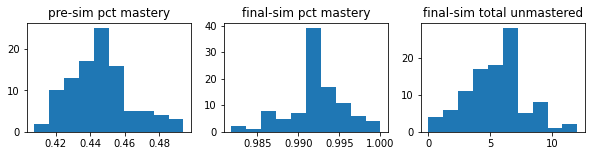

INFO:learner.decider:Total skills: 660


In [64]:
# Plot mastery
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(sim_students['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(132)
plt.hist(sim_students['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")

plt.subplot(133)
plt.hist(sim_students['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()
logger.info("Total skills: %i" % sim_students['total skills'][0])

0: attempt
1: guess
2: hint request
3: off task


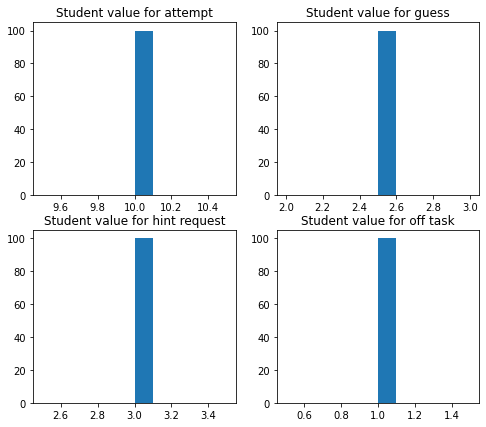

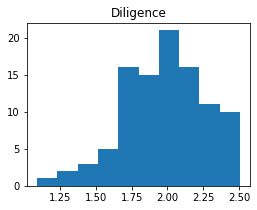

In [65]:
# Plot Values & Diligence
plt.figure(figsize=(8,7))
for i,val in enumerate(sim_students['values'][0].keys()):
    print("%i: %s" % (i, val))
    plt.subplot(2,2,i+1)
    plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
    plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(4,3))
plt.hist(sim_students['diligence'], bins=10)
plt.title("Diligence")
plt.show()



#### Learner Decisions EDA

In [ ]:
# Get Learner decisions
if "stus_1" in globals():
    decisions = pd.DataFrame(db.decisions.find({"student_id": {'$in': [stu._id for stu in stus_1]}}))
else:
    decisions = pd.DataFrame(db.decisions.find({"student_id": {'$in': sids1}}))
decisions['learner_knowledge'] = decisions['learner_knowledge'].apply(lambda x: x[0] if isinstance(x, Iterable) else x)
decisions['kcid'] = decisions['kc'].apply(lambda x: x['_id'])
decisions.head()

#### Learner Actions EDA

In [67]:
action_dist.head()

type,Attempt,Guess,Hint Request,Off Task,total actions,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task
student_id,,,,,,,,,
2fe29b96-37f6-4570-9dfe-a420fcd9adcb,21500,840,6465,2368,31173,0.689699,0.026946,0.207391,0.075963
49f92100-4fe7-42d5-ac5f-83b397200f11,24694,754,7554,2034,35036,0.704818,0.021521,0.215607,0.058055
5dfc6a4f-e6ea-4acf-a737-d09ff251ce0a,24035,805,7131,2033,34004,0.706829,0.023674,0.209711,0.059787
703cdf3d-aa7e-4b7c-bf84-c42f8795981c,24243,639,7213,1782,33877,0.715618,0.018862,0.212917,0.052602
7c953890-0606-42b8-9427-a307cafe753a,21630,844,6847,2210,31531,0.685992,0.026767,0.217151,0.070090


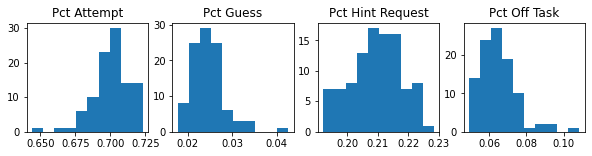

In [68]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Transactions EDA

In [71]:
args = [db, get_tx_fields, sid, 10]
tx, runtime = time_calc(batch_calc, args)
logger.info(f"Extracted tx for set of students in {runtime} seconds: {tx.shape}")

INFO:learner.decider:Extracted tx for set of students in 184.265336 seconds: (3223010, 8)


In [72]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

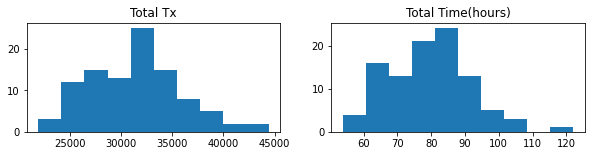

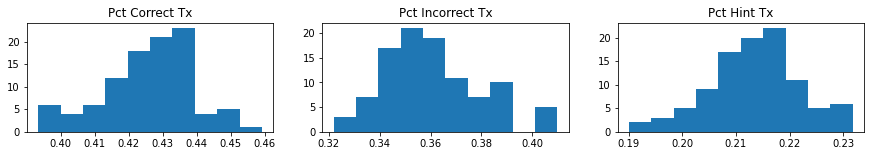

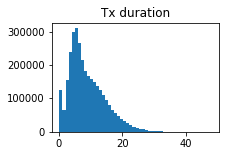

In [73]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(tx_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(tx_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(tx_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(tx_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(tx_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

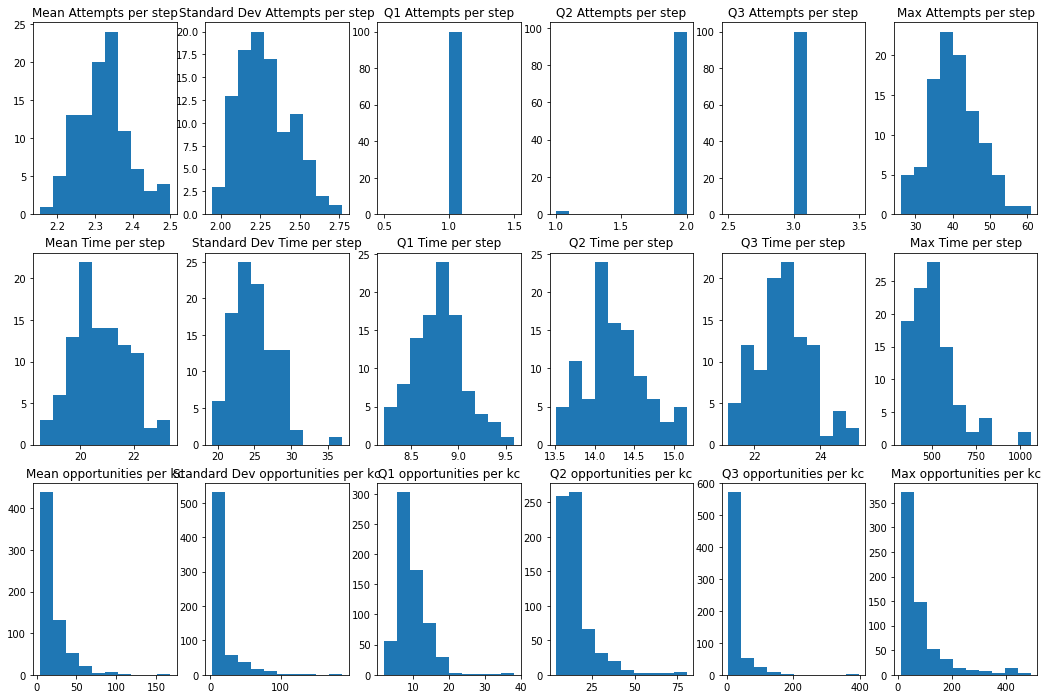

In [75]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


### Diligent with variable values

In [76]:
sid = sids2

In [77]:
args = [db, calc.get_stu_parameters, sid, 10]
sim_students, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

INFO:learner.decider:Calculated student params: (100, 23)	Runtime: 0.298291 seconds


In [78]:
args = [db, calc.action_stats, sid, 10]
action_dist, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

INFO:learner.decider:Calculated student action stats: (100, 9)	Runtime: 241.247932 seconds


In [79]:
args = [db, calc.total_tx_stats, sid, 10]
tx_stats, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")

INFO:learner.decider:Calculated student activity stats: (100, 9)	Runtime: 217.517953 seconds


In [81]:
    
stu_stats = pd.concat([sim_students, action_dist, tx_stats], axis=1)
logger.info(f"Merged new stats together: {stu_stats.shape}")

INFO:learner.decider:Merged new stats together: (100, 41)


#### Student Parameters

In [82]:
sim_students.head()

,domain_id,type,skills,min_off_task,max_off_task,mean_guess_time,sd_guess_time,cog,decider,total_attempts,...,final total success,pre-sim total mastery,final-sim total mastery,total skills,pre-sim pct mastery,final-sim pct mastery,final-sim total unmastered,pct success,values,diligence
_id,,,,,,,,,,,,,,,,,,,,,
0157a057-47aa-44b8-9ec2-a8fe32b76e1a,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,{'2c39f442-a148-414b-afdb-dc643c613cac': False...,30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'RandValDecider', 'values': {'attempt...",0,...,14811,298,655,660,0.451515,0.992424,5,0.571544,"{'attempt': 13.41827590514599, 'guess': 12.556...",2.033161
15c03a2e-d309-48be-b285-b91bdbfd9273,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,"{'2c39f442-a148-414b-afdb-dc643c613cac': True,...",30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'RandValDecider', 'values': {'attempt...",0,...,14958,329,656,660,0.498485,0.993939,4,0.621257,"{'attempt': 7.567166921175709, 'guess': 5.2940...",2.133802
1b1e3d0e-c2f4-45b1-be3d-a330a473c2e4,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,"{'2c39f442-a148-414b-afdb-dc643c613cac': True,...",30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'RandValDecider', 'values': {'attempt...",0,...,16581,304,657,660,0.460606,0.995455,3,0.524582,"{'attempt': 9.470674854367298, 'guess': 9.0257...",1.866326
3e560c70-7cd8-4e33-a603-6cb051bd308d,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,"{'2c39f442-a148-414b-afdb-dc643c613cac': True,...",30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'RandValDecider', 'values': {'attempt...",0,...,15418,307,655,660,0.465152,0.992424,5,0.574078,"{'attempt': 9.666659125431261, 'guess': 7.0825...",1.899707
42bea412-190d-414c-a7d8-8a2111e6a7d4,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,"{'2c39f442-a148-414b-afdb-dc643c613cac': True,...",30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'RandValDecider', 'values': {'attempt...",0,...,12477,284,656,660,0.430303,0.993939,4,0.554829,"{'attempt': 11.140138045709282, 'guess': 8.293...",1.555199


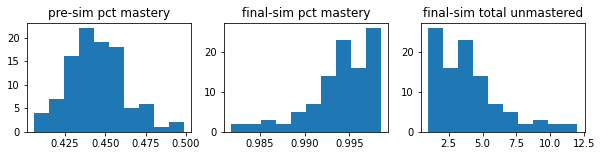

INFO:learner.decider:Total skills: 660


In [83]:
# Plot mastery
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(sim_students['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(132)
plt.hist(sim_students['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")

plt.subplot(133)
plt.hist(sim_students['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()
logger.info("Total skills: %i" % sim_students['total skills'][0])

0: attempt
1: guess
2: hint request
3: off task


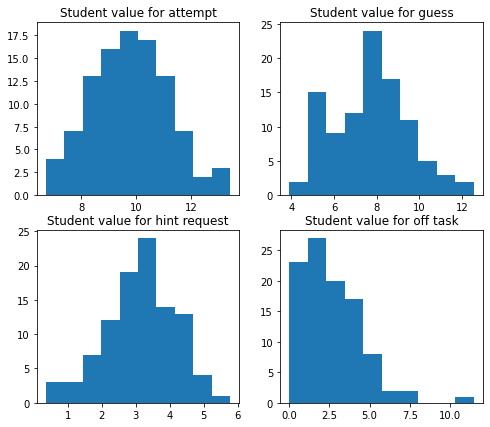

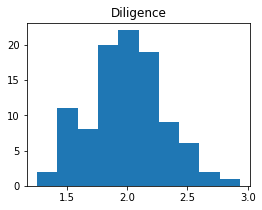

In [84]:
# Plot Values & Diligence
plt.figure(figsize=(8,7))
for i,val in enumerate(sim_students['values'][0].keys()):
    print("%i: %s" % (i, val))
    plt.subplot(2,2,i+1)
    plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
    plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(4,3))
plt.hist(sim_students['diligence'], bins=10)
plt.title("Diligence")
plt.show()



#### Learner Actions EDA

In [85]:
action_dist.head()

type,Attempt,Guess,Hint Request,Off Task,total actions,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task
student_id,,,,,,,,,
0157a057-47aa-44b8-9ec2-a8fe32b76e1a,23055,2859,8855,2866,37635,0.612595,0.075967,0.235286,0.076153
15c03a2e-d309-48be-b285-b91bdbfd9273,22195,1882,9593,10977,44647,0.497122,0.042153,0.214863,0.245862
1b1e3d0e-c2f4-45b1-be3d-a330a473c2e4,27910,3698,8789,6452,46849,0.595744,0.078934,0.187603,0.137719
3e560c70-7cd8-4e33-a603-6cb051bd308d,24350,2507,9630,1859,38346,0.635008,0.065378,0.251134,0.048480
42bea412-190d-414c-a7d8-8a2111e6a7d4,19769,2719,6049,6584,35121,0.562883,0.077418,0.172233,0.187466


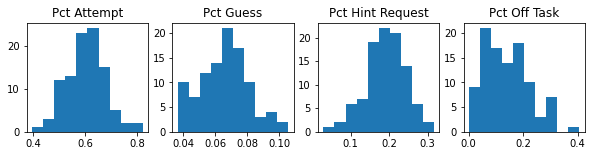

In [86]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Transactions EDA

In [87]:
args = [db, get_tx_fields, sid, 10]
tx, runtime = time_calc(batch_calc, args)
logger.info(f"Extracted tx for set of students in {runtime} seconds: {tx.shape}")

INFO:learner.decider:Extracted tx for set of students in 202.5225 seconds: (3621970, 8)


In [88]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

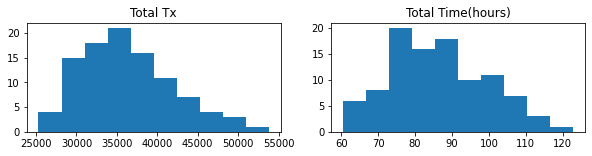

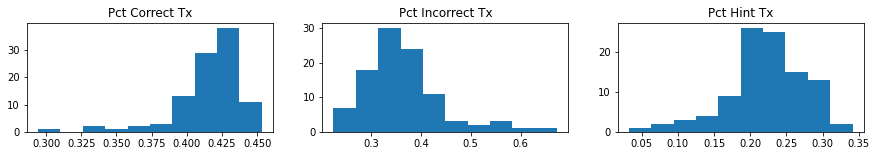

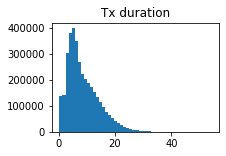

In [89]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(stu_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(stu_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(stu_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(stu_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(stu_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

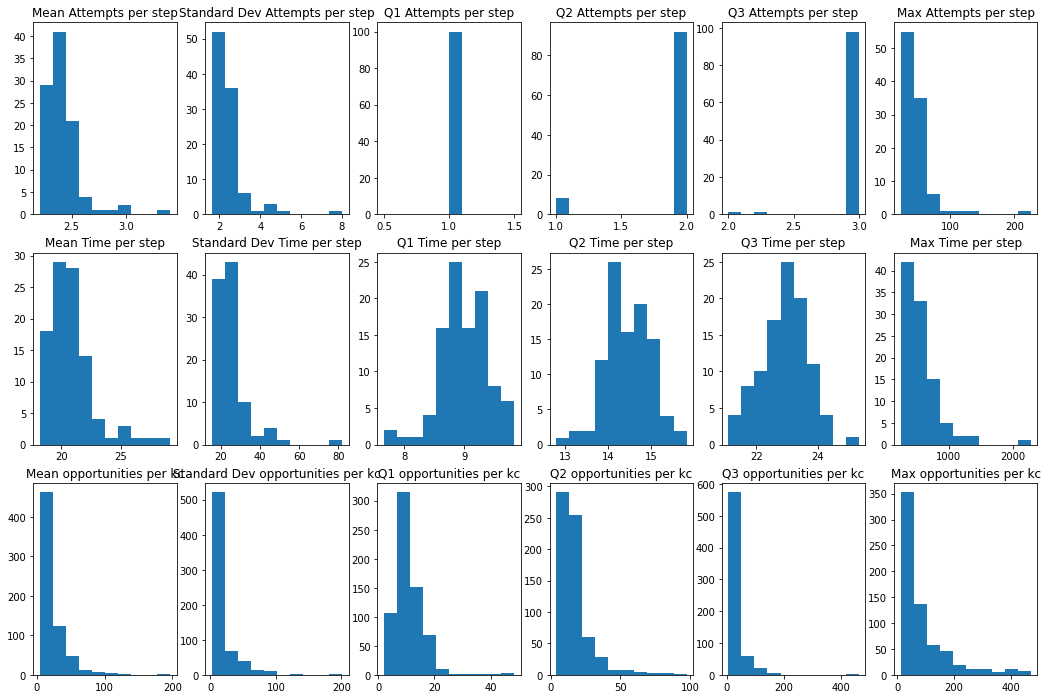

In [90]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


### Diligent with domain-level self-eff

In [91]:
sid = sids3

In [92]:
args = [db, calc.get_stu_parameters, sid, 10]
sim_students, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

INFO:learner.decider:Calculated student params: (100, 23)	Runtime: 0.287216 seconds


In [93]:
args = [db, calc.action_stats, sid, 10]
action_dist, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

INFO:learner.decider:Calculated student action stats: (100, 9)	Runtime: 199.106456 seconds


In [94]:
args = [db, calc.total_tx_stats, sid, 10]
tx_stats, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")

INFO:learner.decider:Calculated student activity stats: (100, 9)	Runtime: 199.494075 seconds


In [95]:
    
stu_stats = pd.concat([sim_students, action_dist, tx_stats], axis=1)
logger.info(f"Merged new stats together: {stu_stats.shape}")

INFO:learner.decider:Merged new stats together: (100, 41)


#### Student Parameters

In [96]:
sim_students.head()

,domain_id,type,skills,min_off_task,max_off_task,mean_guess_time,sd_guess_time,cog,decider,total_attempts,...,final total success,pre-sim total mastery,final-sim total mastery,total skills,pre-sim pct mastery,final-sim pct mastery,final-sim total unmastered,pct success,values,diligence
_id,,,,,,,,,,,,,,,,,,,,,
0a8b4747-e859-4cd2-9ce1-26da47c92e7b,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,{'2c39f442-a148-414b-afdb-dc643c613cac': False...,30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'DomainSelfEffDecider', 'values': {'a...",0,...,11781,280,657,660,0.424242,0.995455,3,0.586324,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.071282
1277b7d5-78a5-44be-9ac4-1720bb06d8e4,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,{'2c39f442-a148-414b-afdb-dc643c613cac': False...,30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'DomainSelfEffDecider', 'values': {'a...",0,...,15302,288,652,660,0.436364,0.987879,8,0.540363,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",1.857240
1505e38b-a188-468d-a8d3-412018d27f51,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,{'2c39f442-a148-414b-afdb-dc643c613cac': False...,30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'DomainSelfEffDecider', 'values': {'a...",0,...,12307,294,657,660,0.445455,0.995455,3,0.549174,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",1.885145
151070f6-1947-45b3-a952-9a423e05963a,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,"{'2c39f442-a148-414b-afdb-dc643c613cac': True,...",30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'DomainSelfEffDecider', 'values': {'a...",0,...,13546,322,655,660,0.487879,0.992424,5,0.547512,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",1.573397
30007d49-4979-40e5-8335-7ef0cb33a828,0c7a02e1-c921-4a8a-82fe-6fbdb058dc52,Modular Learner,"{'2c39f442-a148-414b-afdb-dc643c613cac': True,...",30,1800,3,1,{'domain_id': '0c7a02e1-c921-4a8a-82fe-6fbdb05...,"{'type': 'DomainSelfEffDecider', 'values': {'a...",0,...,16200,292,655,660,0.442424,0.992424,5,0.523205,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.230488


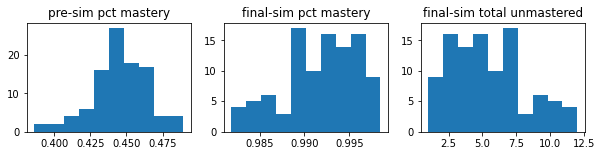

INFO:learner.decider:Total skills: 660


In [97]:
# Plot mastery
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(sim_students['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(132)
plt.hist(sim_students['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")

plt.subplot(133)
plt.hist(sim_students['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()
logger.info("Total skills: %i" % sim_students['total skills'][0])

0: attempt
1: guess
2: hint request
3: off task


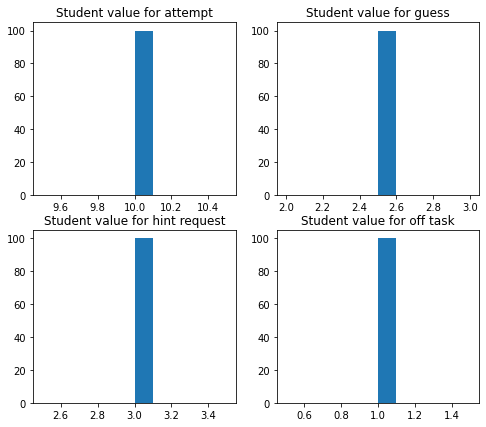

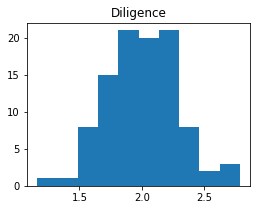

In [98]:
# Plot Values & Diligence
plt.figure(figsize=(8,7))
for i,val in enumerate(sim_students['values'][0].keys()):
    print("%i: %s" % (i, val))
    plt.subplot(2,2,i+1)
    plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
    plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(4,3))
plt.hist(sim_students['diligence'], bins=10)
plt.title("Diligence")
plt.show()



#### Learner Actions EDA

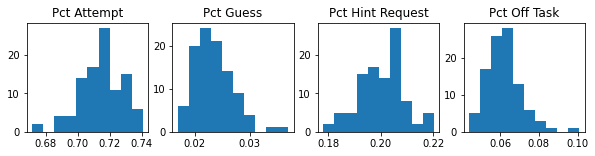

In [99]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Transactions EDA

In [100]:
args = [db, get_tx_fields, sid, 10]
tx, runtime = time_calc(batch_calc, args)
logger.info(f"Extracted tx for set of students in {runtime} seconds: {tx.shape}")

INFO:learner.decider:Extracted tx for set of students in 181.47625 seconds: (3157632, 8)


In [101]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

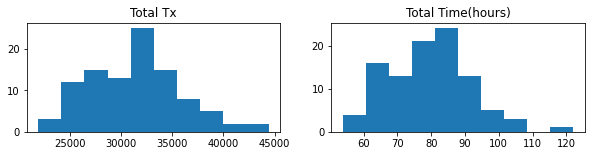

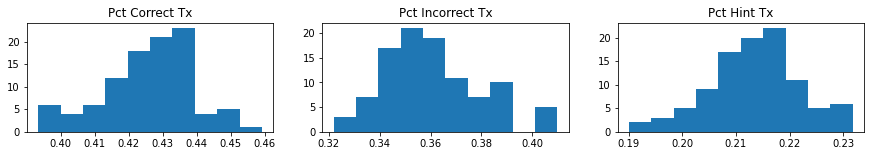

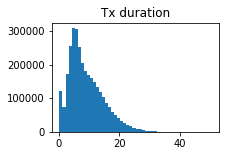

In [102]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(stu_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(stu_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(stu_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(stu_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(stu_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

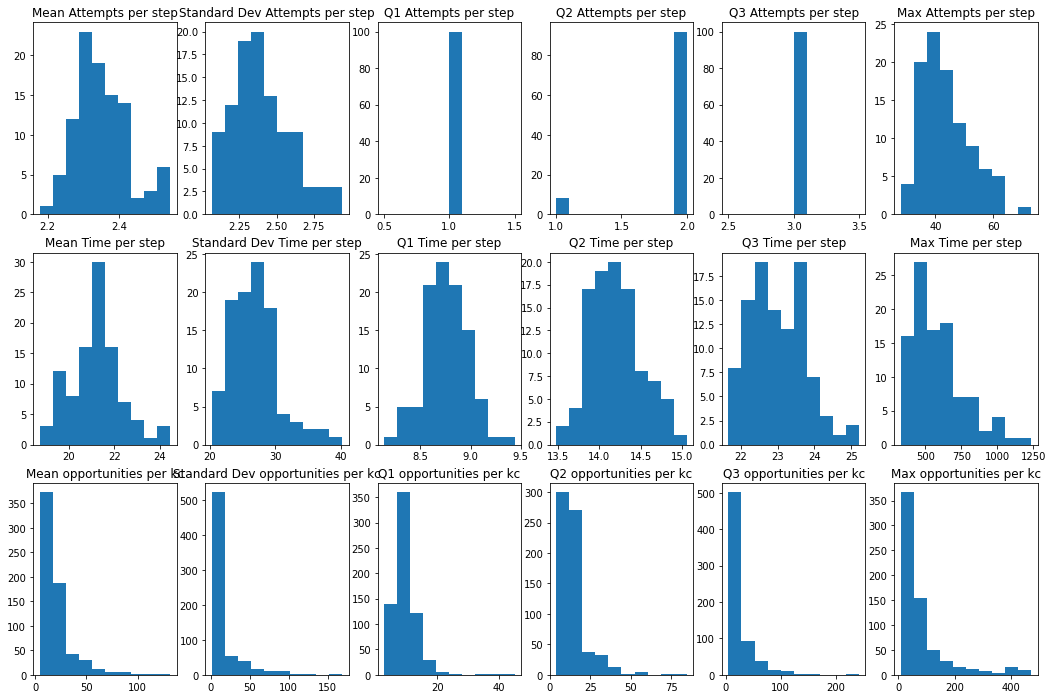

In [103]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


## 3. Estimating Diligence

In [104]:
print("test")

test


In [120]:
# Get Simple Diligent students
batches = [batch for batch in db.simbatches.find()]
batch_desc = ["Simple diligent students",
              "Diligent Students with variable values",
              "Diligent Students with domain-level self-efficacy"]
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \tID: {batch['_id']}\tdesc: {batch['desc']}")
    if batch['desc'] == batch_desc[0]:
        logger.info("recovered student ids for batch 1")
        sids1 = batch['student_ids']
    elif batch['desc'] == batch_desc[1]:
        logger.info("recovered student ids for batch 2")
        sids2 = batch['student_ids']
    elif batch['desc'] == batch_desc[2]:
        logger.info("recovered student ids for batch 3")
        sids3 = batch['student_ids']
        

INFO:learner.decider:batch #0: 	ID: 2abb0888-a975-4ad0-808f-cf33e7e491e7	desc: Simple diligent students
INFO:learner.decider:recovered student ids for batch 1
INFO:learner.decider:batch #1: 	ID: 8440828a-d3e5-4b07-89a9-d1a3db302f12	desc: Diligent Students with variable values
INFO:learner.decider:recovered student ids for batch 2
INFO:learner.decider:batch #2: 	ID: 551d5cdc-b4a5-47b6-bc9c-d53851a80bda	desc: Diligent Students with domain-level self-efficacy
INFO:learner.decider:recovered student ids for batch 3


In [42]:
# Batch analytic calculation
def batch_calc(db, calc, filt, batch_size, ):
    #filt is a list of ids
    batches = (filt[i:i+batch_size] for i in range(0, len(filt), batch_size))
    results = []
    for batch in batches:
        results.append(calc(batch))
    return pd.concat(results, axis=0)

In [43]:
def time_calc(calc, args):
    start = dt.now()
    result = calc(*args)
    end = dt.now()
    runtime = (end - start).total_seconds()
    return result, runtime

In [44]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)

In [121]:
sids = [sids1, sids2, sids3]
stu_stats = []
for i, sid in enumerate(sids):
    logger.info(f"Calculating for student set {i}")
    args = [db, calc.get_stu_parameters, sid, 10]
    sim_students, runtime = time_calc(batch_calc, args)
    logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

    args = [db, calc.action_stats, sid, 10]
    action_dist, runtime = time_calc(batch_calc, args)
    logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

    args = [db, calc.total_tx_stats, sid, 10]
    tx_stats, runtime = time_calc(batch_calc, args)
    logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")
    
    stu_stats.append(pd.concat([sim_students, action_dist, tx_stats], axis=1))
    logger.info(f"Merged new stats together: {stu_stats[i].shape}")


INFO:learner.decider:Calculating for student set 0
INFO:learner.decider:Calculated student params: (100, 23)	Runtime: 0.330968 seconds
INFO:learner.decider:Calculated student action stats: (100, 9)	Runtime: 205.442505 seconds
INFO:learner.decider:Calculated student activity stats: (100, 9)	Runtime: 201.603126 seconds
INFO:learner.decider:Merged new stats together: (100, 41)
INFO:learner.decider:Calculating for student set 1
INFO:learner.decider:Calculated student params: (100, 23)	Runtime: 0.285056 seconds
INFO:learner.decider:Calculated student action stats: (100, 9)	Runtime: 238.736617 seconds
INFO:learner.decider:Calculated student activity stats: (100, 9)	Runtime: 217.185962 seconds
INFO:learner.decider:Merged new stats together: (100, 41)
INFO:learner.decider:Calculating for student set 2
INFO:learner.decider:Calculated student params: (100, 23)	Runtime: 0.272423 seconds
INFO:learner.decider:Calculated student action stats: (100, 9)	Runtime: 202.43722 seconds
INFO:learner.decider:

In [49]:
# Compare contents of columns to check if stats are distinct
for i, col in enumerate(stu_stats[1].columns):
    print(f"{i}#: {col} - {stu_stats[0].columns[i] == stu_stats[1].columns[i]}")

0#: domain_id - True
1#: type - True
2#: skills - True
3#: min_off_task - True
4#: max_off_task - True
5#: mean_guess_time - True
6#: sd_guess_time - True
7#: cog - True
8#: decider - True
9#: total_attempts - True
10#: total_success - True
11#: final skills - True
12#: final total attempts - True
13#: final total success - True
14#: pre-sim total mastery - True
15#: final-sim total mastery - True
16#: total skills - True
17#: pre-sim pct mastery - True
18#: final-sim pct mastery - True
19#: final-sim total unmastered - True
20#: pct success - True
21#: values - True
22#: diligence - True
23#: Attempt - True
24#: Guess - True
25#: Hint Request - True
26#: Off Task - True
27#: total actions - True
28#: Pct Attempt - True
29#: Pct Guess - True
30#: Pct Hint Request - True
31#: Pct Off Task - True
32#: Total Tx - True
33#: Total Time - True
34#: Total Time(hours) - True
35#: Correct - True
36#: Hint - True
37#: Incorrect - True
38#: Pct Correct - True
39#: Pct Hint - True
40#: Pct Incorre

### Time on Task

TypeError: string indices must be integers

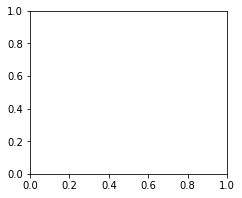

In [106]:
xcol = "diligence"
ycol = "Total Time(hours)"
plt.figure(figsize=(12,3))
plt.title("Diligence vs Observed Off task")

for i, stat in enumerate(stu_stats):
    plt.subplot(1,3,i+1)    
    plt.scatter(stat[xcol], stat[ycol])
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()

xcol = "pre-sim pct mastery"
ycol = "Total Time(hours)"
plt.figure(figsize=(12,3))
plt.title("Init Mastery vs Time")

for i, stat in enumerate(stu_stats):
    plt.subplot(1,3,i+1)    
    plt.scatter(stat[xcol], stat[ycol])
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()

### Freq of Off-task

INFO:learner.decider:student set #0: R = -0.715566274642269	 pval = 5.991886729854099e-17
INFO:learner.decider:student set #1: R = -0.17844401923678888	 pval = 0.0756849370601294
INFO:learner.decider:student set #2: R = -0.5823832162228163	 pval = 2.071615854517511e-10


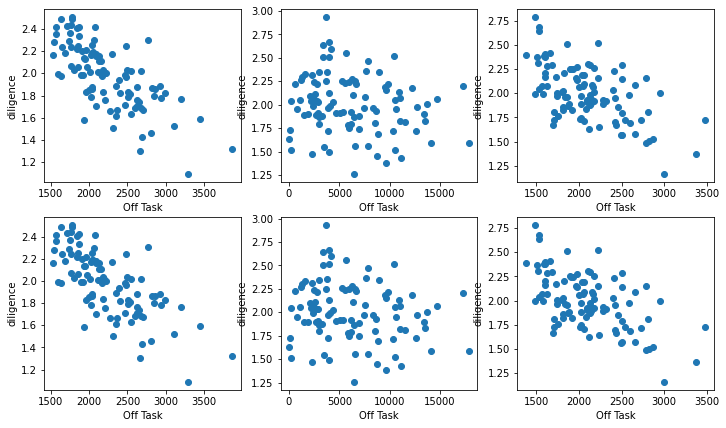

In [52]:
xcol = "Off Task"
ycol = "diligence"
plt.figure(figsize=(12,7))
plt.title("Diligence vs Observed Off task")

for i, stat in enumerate(stu_stats):
    d1 = stat[xcol]
    d2 = stat[ycol]
    corr, pval = pearsonr(d1, d2)
    logger.info(f"student set #{i}: R = {corr}\t pval = {pval}")
    plt.subplot(2,3,i+1)    
    plt.scatter(stat[xcol], stat[ycol])
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.subplot(2,3,3+i+1)    
    plt.scatter(d1, d2)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
plt.show()

In [55]:
i = 0
stat = stu_stats[i]
X = stat.loc[:, ["Off Task"]]
Y = stat.loc[:, ["diligence"]]
model = sm.OLS(Y, X)
result = model.fit()
logger.info(result.t_test([1]))

INFO:learner.decider:                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0008   2.76e-05     30.098      0.000       0.001       0.001


### Proportion of Off-task

INFO:learner.decider:student set #0: R = -0.9641783903794466	 pval = 2.7523832533434402e-58
INFO:learner.decider:student set #1: R = -0.19906953815672357	 pval = 0.04707909209931672
INFO:learner.decider:student set #2: R = -0.9283316535964442	 pval = 6.633899022228601e-44


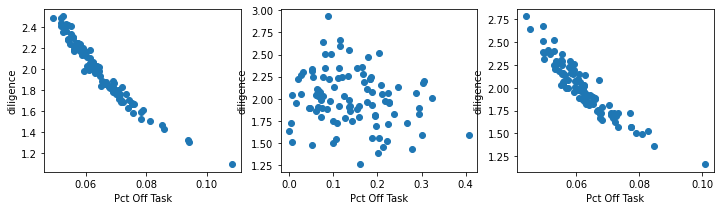

In [60]:
xcol = "Pct Off Task"
ycol = "diligence"
plt.figure(figsize=(12,3))
plt.title("Diligence vs Proportion Off task")

for i, stat in enumerate(stu_stats):
    d1 = stat[xcol]
    d2 = stat[ycol]
    corr, pval = pearsonr(d1, d2)
    logger.info(f"student set #{i}: R = {corr}\t pval = {pval}")
    plt.subplot(1,3,i+1)       
    plt.scatter(d1, d2)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
plt.show()

In [113]:
stu_stats['Value: Off Task'] = stu_stats.apply(lambda x: x['values']["off task"], axis=1)

In [112]:
stu_stats.loc[:,'values'].head()

0a8b4747-e859-4cd2-9ce1-26da47c92e7b    {'attempt': 10, 'guess': 2.5, 'hint request': ...
1277b7d5-78a5-44be-9ac4-1720bb06d8e4    {'attempt': 10, 'guess': 2.5, 'hint request': ...
1505e38b-a188-468d-a8d3-412018d27f51    {'attempt': 10, 'guess': 2.5, 'hint request': ...
151070f6-1947-45b3-a952-9a423e05963a    {'attempt': 10, 'guess': 2.5, 'hint request': ...
30007d49-4979-40e5-8335-7ef0cb33a828    {'attempt': 10, 'guess': 2.5, 'hint request': ...
Name: values, dtype: object

In [115]:
stats = stu_stats

In [119]:
xcols = ["diligence", "Value: Off Task"]
ycol = "Pct Off Task"
X = stats.loc[:, xcols]
Y = stats.loc[:, ycol]
mdl = sm.OLS(Y, X).fit()
logger.info(mdl.summary())


INFO:learner.decider:                            OLS Regression Results                            
Dep. Variable:           Pct Off Task   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     611.1
Date:                Tue, 01 Dec 2020   Prob (F-statistic):           6.63e-44
Time:                        20:27:37   Log-Likelihood:                 429.47
No. Observations:                 100   AIC:                            -854.9
Df Residuals:                      98   BIC:                            -849.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
diligence          -0

### BIRT

## Comparing Diligence Estimates

In [ ]:
print("test")